#### Introduction

Problem Statement:

>The challenge is to develop an AI-driven media investment plan for e-commerce businesses, aimed at optimizing budget allocation across various paid media channels to maximize customer acquisition and conversion rates. The problem involves analyzing customer journey data, understanding the performance of different ad channels at various stages, and using machine learning to identify trends and patterns. The ultimate goal is to reallocate the budget to different channels based on insights derived from data analysis to maximize conversion rates and improve return on investment (ROI).

Solution Approach 

- Data Collection and Preprocessing

- Analysing the various parameters and customer's behaviour.

- Analysing trends and patterns to optimize the conversion rates.

- Feature Engineering.

- Apply machine learning techniques to analyze the processed data. 

- Based on the insights gained from the machine learning analysis, reallocate the budget across different paid media channels adhering to the constraints.

- Document the entire process, including data processing, algorithm development, assumptions made, and results obtained.

In [1]:
# Libraries Used
%pip install pandas==2.2.1
%pip install numpy==1.24.4
%pip install scikit-learn==1.2.2
%pip install matplotlib==3.6.3
%pip install skimpy==0.0.15
%pip install seaborn==0.12.2
%pip install ipywidgets==8.0.6
%pip install plotly==5.14.1

> 📝 **Note:** 
>
> <u>'Jupyter Notebook Renderers'</u> plugin may needed if you want to run the code for allocating the Budget in VS Code in Interactive mode (running ipywidgets).
>
> In case of any error related to installing libraries, run the above cell again and restart the session.

Importing necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import joblib
import ipywidgets as widgets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', None)

#### Reading and Loading the data

The datasets are stored in the following locations:

-  Folder: `Copy of Netelixir AIgnition Dataset 1`
    - Folder: `Netelixir AIgnition Dataset 1`
        - Files:
          - `googleads-performance.csv`
          - `metaads-performance.csv`
          - `microsoftads-performance.csv`
          - `website-landings.csv`

-  Folder: `Copy of Netelixir AIgnition Dataset 2`
    - Folder: `Netelixir AIgnition Dataset 2`
        - Files:
          - `googleads-performance.csv`
          - `metaads-performance.csv`
          - `microsoftads-performance.csv`
          - `website-landings.csv`

In [3]:
folders = [
    'Copy of Netelixir AIgnition Dataset 1/Netelixir AIgnition Dataset 1/',
    'Copy of Netelixir AIgnition Dataset 2/Netelixir AIgnition Dataset 2/'
]

files = ['googleads-performance.csv', 'metaads-performance.csv', 'microsoftads-performance.csv', 'website-landings.csv']

dataframes = {}

for file in files:
    df_list = [pd.read_csv(folder + file) for folder in folders]
    dataframes[file.split('-')[0]] = pd.concat(df_list, ignore_index=True)
    
google_ads_df = dataframes['googleads']
meta_ads_df = dataframes['metaads']
microsoft_ads_df = dataframes['microsoftads']
website_data = dataframes['website']

In [4]:
google_ads_df.sample(2)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue
889,2024-02-28,Display Network,1632.0,183.0,22.2,1.2,318.5
863,2024-02-19,Search Network,7629.0,940.0,971.9,72.8,14487.6


In [5]:
meta_ads_df.sample(2)

,Date,Impressions,Reach,Cost,Clicks,Conversions,Revenue
157,2024-06-06,14337.0,8100.0,125.8,175.0,20.0,9142.1
40,2024-02-10,13963.0,10172.0,98.6,348.0,2.0,84.0


In [6]:
microsoft_ads_df.sample(2)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue
803,2024-02-11,Search & content,249.0,80.0,159.9,15.0,1989.6
142,2024-02-07,Performance max,2411.0,11.0,14.2,0.0,0.0


In [7]:
website_data.sample(2)

,User Id,Website Landing Time,Is Converted,Source,Channel,Campaign Type
869107,5acaa10c,2024-03-21 11:45:43,0,bing,paid,Search & content
2463220,7d8ed4e0,2024-02-03 16:57:52,0,NaN,direct,NaN


#### Preprocessing the data

In [8]:
def preprocess_ads_data(df, platform):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Platform'] = platform
    return df

In [9]:
google_ads_df = preprocess_ads_data(google_ads_df, 'Google Ads')
meta_ads_df = preprocess_ads_data(meta_ads_df, 'Meta Ads')
microsoft_ads_df = preprocess_ads_data(microsoft_ads_df, 'Microsoft Ads')

Merging all ads platforms to a single data frame

In [10]:
data = pd.concat([google_ads_df, meta_ads_df, microsoft_ads_df], axis=0)

Filling the missing values/null values/infinite values

In [11]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [12]:
website_data['Source'].fillna('Unknown', inplace=True)
website_data['Campaign Type'].fillna('Unknown', inplace=True)

In [13]:
data['Campaign type'] = data['Campaign type'].astype('category')
data['Platform'] = data['Platform'].astype('category')

In [14]:
website_data['Website Landing Time'] =pd.to_datetime(website_data['Website Landing Time'], format='%Y-%m-%d %H:%M:%S')
website_data['Is Converted'] = website_data['Is Converted'].astype(int)

website_data['Hour'] = website_data['Website Landing Time'].dt.hour
website_data['Day of Week'] = website_data['Website Landing Time'].dt.day_name()

#### Data Exploration

>> Here, I have combined the data from all the ADs Platform but we will explore the **ADs Data** and **Website Data** seperately as both the   dataframe contains different values and parameters. and so we will later try to draw some insights from both the data.

In [15]:
data.sample(3)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Reach
503,2024-05-08,YouTube,16504.0,6.0,66.2,0.0,0.0,Google Ads,0.0
205,2024-01-24,0,12204.0,158.0,99.1,0.0,0.0,Meta Ads,6167.0
697,2024-06-26,YouTube,27224.0,20.0,232.2,0.2,7.8,Google Ads,0.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2633 entries, 0 to 1084
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2633 non-null   datetime64[ns]
 1   Campaign type  2633 non-null   category      
 2   Impressions    2633 non-null   float64       
 3   Clicks         2633 non-null   float64       
 4   Cost           2633 non-null   float64       
 5   Conversions    2633 non-null   float64       
 6   Revenue        2633 non-null   float64       
 7   Platform       2633 non-null   category      
 8   Reach          2633 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(6)
memory usage: 170.2 KB


In [17]:
data.nunique()

Date              182
Campaign type       9
Impressions      2446
Clicks           1056
Cost             1918
Conversions       606
Revenue          1962
Platform            3
Reach             360
dtype: int64

In [18]:
website_data.sample(3)

,User Id,Website Landing Time,Is Converted,Source,Channel,Campaign Type,Hour,Day of Week
2531848,e72c03a2,2024-02-08 14:13:30,0,Unknown,referral,Unknown,14,Thursday
117113,04a4b163,2024-05-05 12:04:10,0,Unknown,email,Unknown,12,Sunday
718965,334ca645,2024-03-02 14:12:58,0,bing,paid,Shopping,14,Saturday


In [19]:
website_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4499425 entries, 0 to 4499424
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   User Id               object        
 1   Website Landing Time  datetime64[ns]
 2   Is Converted          int32         
 3   Source                object        
 4   Channel               object        
 5   Campaign Type         object        
 6   Hour                  int32         
 7   Day of Week           object        
dtypes: datetime64[ns](1), int32(2), object(5)
memory usage: 240.3+ MB


In [20]:
website_data.nunique()

User Id                 2761778
Website Landing Time    3757177
Is Converted                  2
Source                       59
Channel                       8
Campaign Type                 9
Hour                         24
Day of Week                   7
dtype: int64

In [21]:
print(data.describe(include='category'))

        Campaign type    Platform
count            2633        2633
unique              9           3
top                 0  Google Ads
freq              364        1184


In [22]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 2633   │ │ float64     │ 6     │ │ Campaign type         │                                │
│ │ Number of columns │ 9      │ │ category    │ 2     │ │ Platform              │                                │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │ └───────────────────────┘                                │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %   ┃ mean    ┃ sd       ┃ p0  ┃ p25    ┃ p50     ┃ p75     ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Impressions     │   0 │      0 │   59220 │   108200 │   0 │   5365 │   14340 │   46430 │  698200 │   ▇▁    │  │
│ │ Clicks          │   0 │      0 │   542.6 │    796.1 │   0 │     65 │     245 │     592 │   13430 │   ▇▁    │  │
│ │ Cost            │   0 │      0 │   618.8 │    977.8 │   0 │   61.4 │   136.4 │   818.5 │    6218 │   ▇▁▁   │  │
│ │ Conversions     │   0 │      0 │   23.95 │    36.43 │   0 │    0.1 │       9 │      30 │   213.9 │   ▇▁▁   │  │
│ │ Revenue         │   0 │      0 │    4134 │     5938 │   0 │      4 │    1259 │    6133 │   33530 │   ▇▁▁   │  │
│ │ Reach           │   0 │      0 │    1543 │     4116 │   0 │      0 │       0 │       0 │   27260 │   ▇ ▁   │  │
│ └─────────────────┴─────┴────────┴─────────┴──────────┴─────┴────────┴─────────┴─────────┴─────────┴─────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                          ┃ NA       ┃ NA %          ┃ ordered              ┃ unique            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ Campaign type                        │        0 │             0 │ False                │                 9 │  │
│ │ Platform                             │        0 │             0 │ False                │                 3 │  │
│ └──────────────────────────────────────┴──────────┴───────────────┴──────────────────────┴───────────────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ Date                   │      0 │         0 │     2024-01-01      │     2024-06-30      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [23]:
skim(website_data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 4499425 │ │ string      │ 5     │                                                         │
│ │ Number of columns │ 8       │ │ int32       │ 2     │                                                         │
│ └───────────────────┴─────────┘ │ datetime64  │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean       ┃ sd        ┃ p0   ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ Is Converted      │    0 │      0 │    0.01996 │    0.1398 │    0 │     0 │     0 │    0 │     1 │    ▇    │  │
│ │ Hour              │    0 │      0 │      12.32 │     7.258 │    0 │     6 │    14 │   18 │    23 │ ▆▃▃▆▇▆  │  │
│ └───────────────────┴──────┴────────┴────────────┴───────────┴──────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ first                   ┃ last                    ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ Website Landing Time      │   0 │      0 │   2024-01-01 00:00:25   │   2024-07-01 00:01:11   │ None        │  │
│ └───────────────────────────┴─────┴────────┴─────────────────────────┴─────────────────────────┴─────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ User Id                      │      0 │          0 │                           1 │                 4499425 │  │
│ │ Source                       │      0 │          0 │                           1 │                 4499625 │  │
│ │ Channel                      │      0 │          0 │                         1.1 │                 4883180 │  │
│ │ Campaign Type                │      0 │          0 │                         1.1 │                 4976428 │  │
│ │ Day of Week                  │      0 │          0 │                           1 │                 4499425 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Exploratory Data Analysis (EDA)
> We will now try to undersatnd the data. begin by looking at the distribution of data across the dataset, followed by visualizing the data to understand the relationship between the features and the target variable.

#### EDA - Ads Data

In [24]:
grouped_vals = data.groupby(['Campaign type', 'Platform'], observed=True)

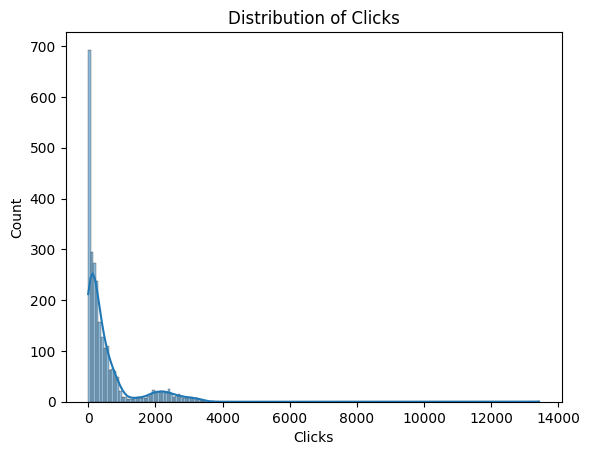

In [25]:
sns.histplot(data['Clicks'], kde=True)
plt.title('Distribution of Clicks')
plt.show()

Time series plots for Google Ads metrics only

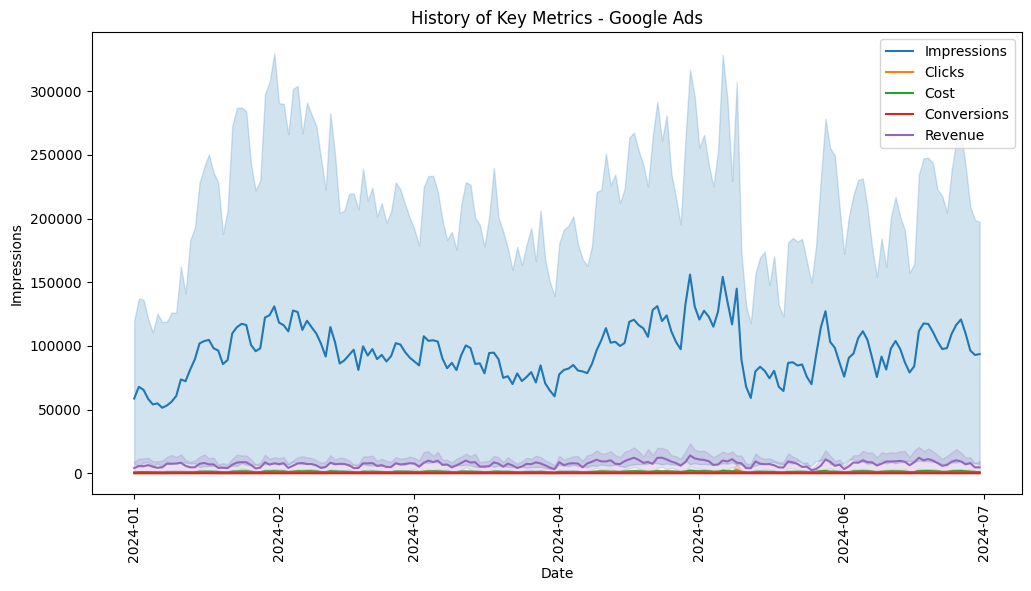

In [26]:
metrics = ['Impressions', 'Clicks','Cost', 'Conversions','Revenue']
plt.figure(figsize=(12, 6))
for metric in metrics:
    sns.lineplot(x='Date', y=metric, data=google_ads_df, label=metric)

plt.title('History of Key Metrics - Google Ads')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Time series plots for Meta Ads metrics

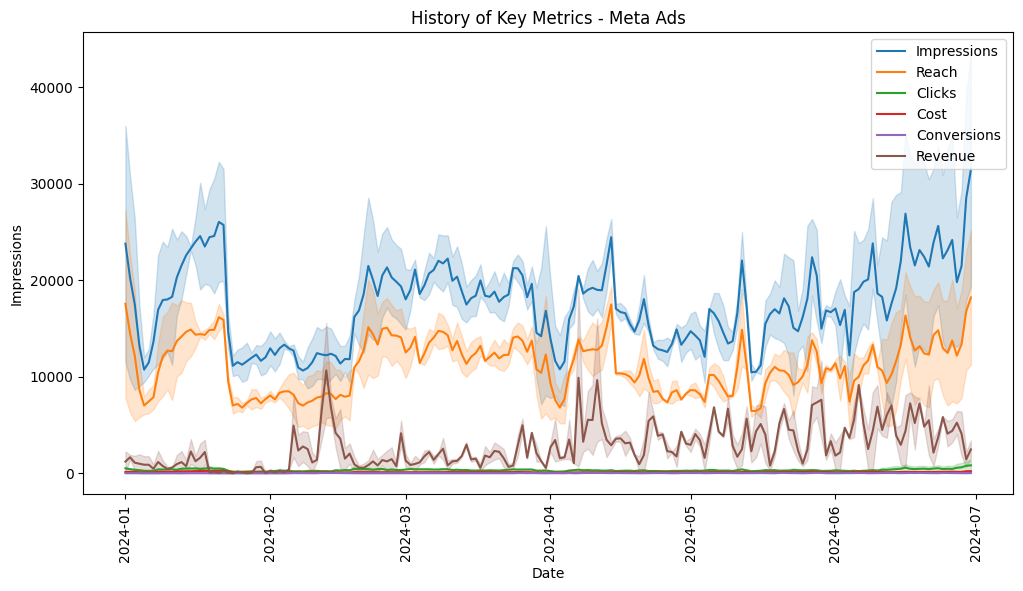

In [27]:
metrics = ['Impressions','Reach', 'Clicks','Cost', 'Conversions','Revenue']
plt.figure(figsize=(12, 6))
for metric in metrics:
    sns.lineplot(x='Date', y=metric, data=meta_ads_df, label=metric)

plt.title('History of Key Metrics - Meta Ads')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Time series plots for Microsoft Ads metrics

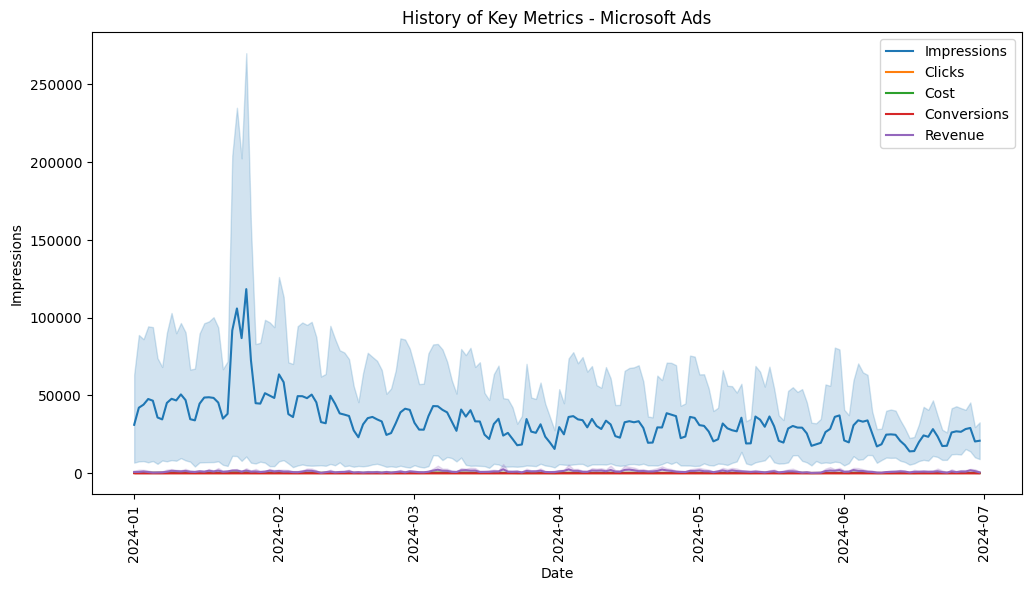

In [28]:
metrics = ['Impressions', 'Clicks','Cost', 'Conversions','Revenue']
plt.figure(figsize=(12, 6))
for metric in metrics:
    sns.lineplot(x='Date', y=metric, data=microsoft_ads_df, label=metric)

plt.title('History of Key Metrics - Microsoft Ads')
plt.xticks(rotation=90)
plt.legend()
plt.show()

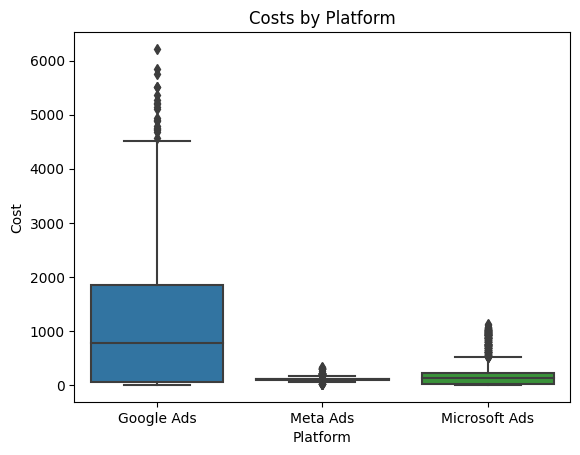

In [29]:
sns.boxplot(x='Platform', y='Cost', data=data)
plt.title('Costs by Platform')
plt.show()

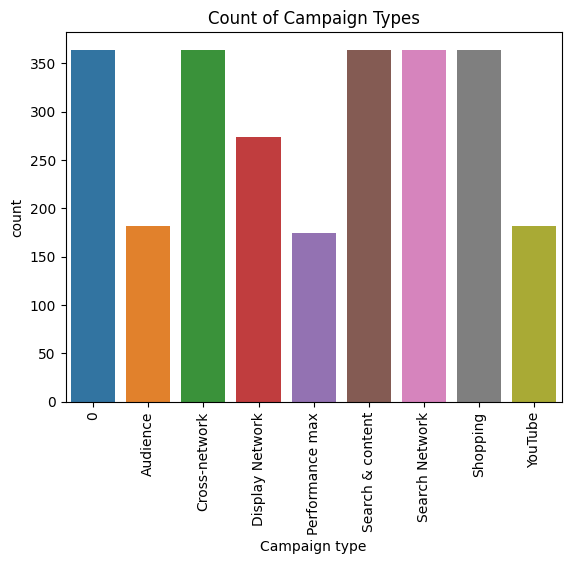

In [30]:
sns.countplot(x='Campaign type', data=data)
plt.title('Count of Campaign Types')
plt.xticks(rotation=90)
plt.show()

#### EDA - Website Data

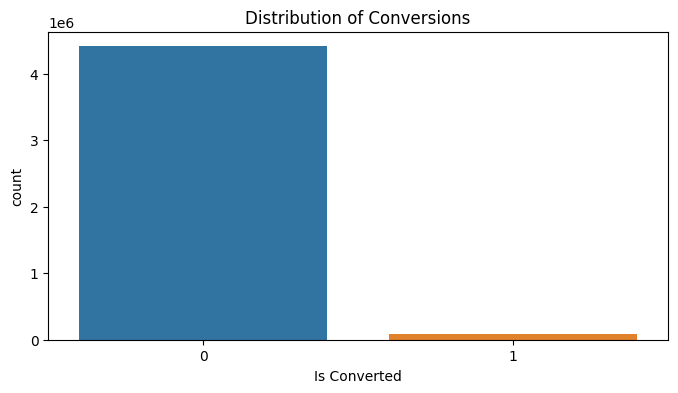

In [31]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Is Converted', data=website_data)
plt.title('Distribution of Conversions')
plt.show()

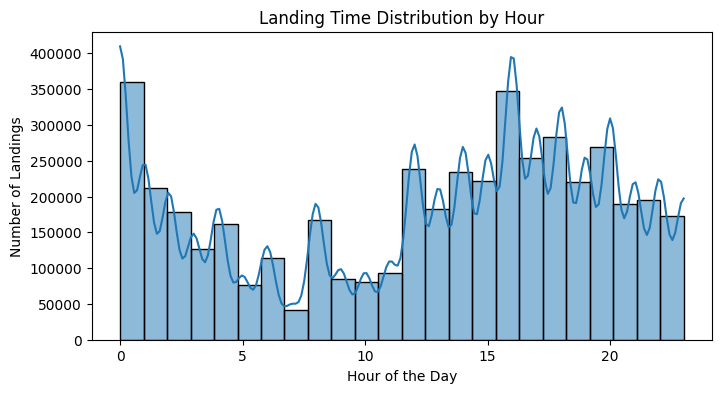

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(website_data['Hour'], bins=24, kde=True)
plt.title('Landing Time Distribution by Hour')
plt.ylabel('Number of Landings')
plt.xlabel('Hour of the Day')
plt.show()

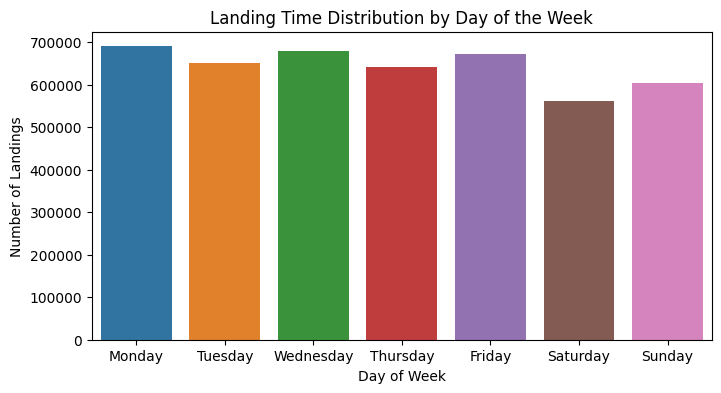

In [33]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Day of Week', data=website_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Landing Time Distribution by Day of the Week')
plt.ylabel("Number of Landings")
plt.show()

Conversion rate analysis - website data

Overall Conversion Rate: 2.00%
Channel
referral          0.042484
direct            0.022469
paid              0.019120
email             0.014679
organic search    0.013707
paid search       0.011000
display           0.003137
social            0.002939
Name: Is Converted, dtype: float64


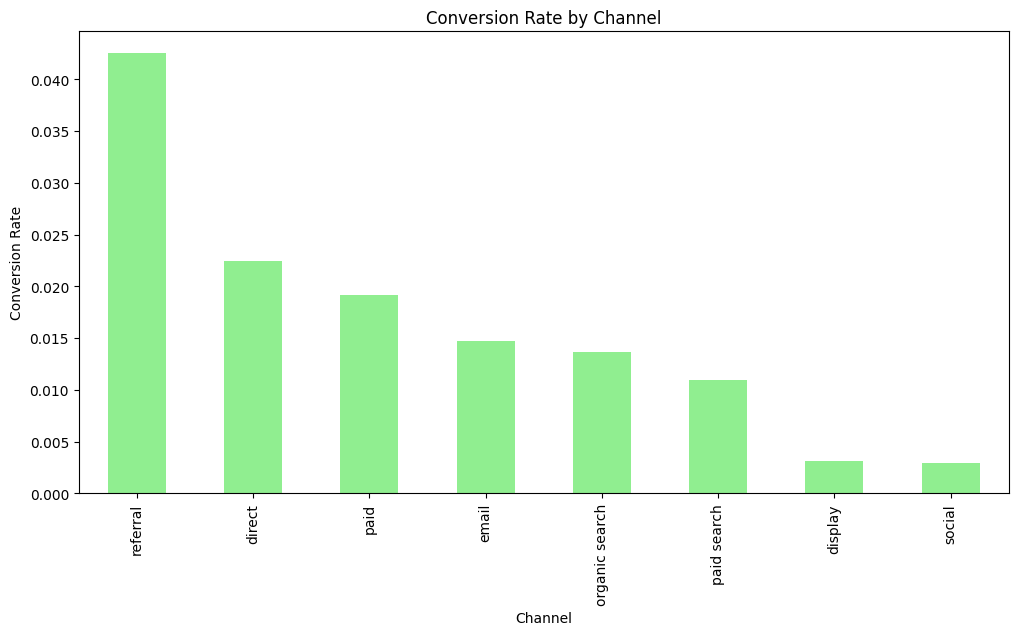

In [34]:
# Calculate overall conversion rate
conversion_rate = website_data['Is Converted'].mean()
print(f"Overall Conversion Rate: {conversion_rate:.2%}")

# Calculate conversion rate by channel
conversion_rate_by_channel = website_data.groupby('Channel')['Is Converted'].mean().sort_values(ascending=False)
print(conversion_rate_by_channel)

# Plot conversion rate by channel
plt.figure(figsize=(12, 6))
conversion_rate_by_channel.plot(kind='bar', color='lightgreen')
plt.title('Conversion Rate by Channel')
plt.ylabel('Conversion Rate')
plt.xlabel('Channel')
plt.show()


Traffic source analysis - website data

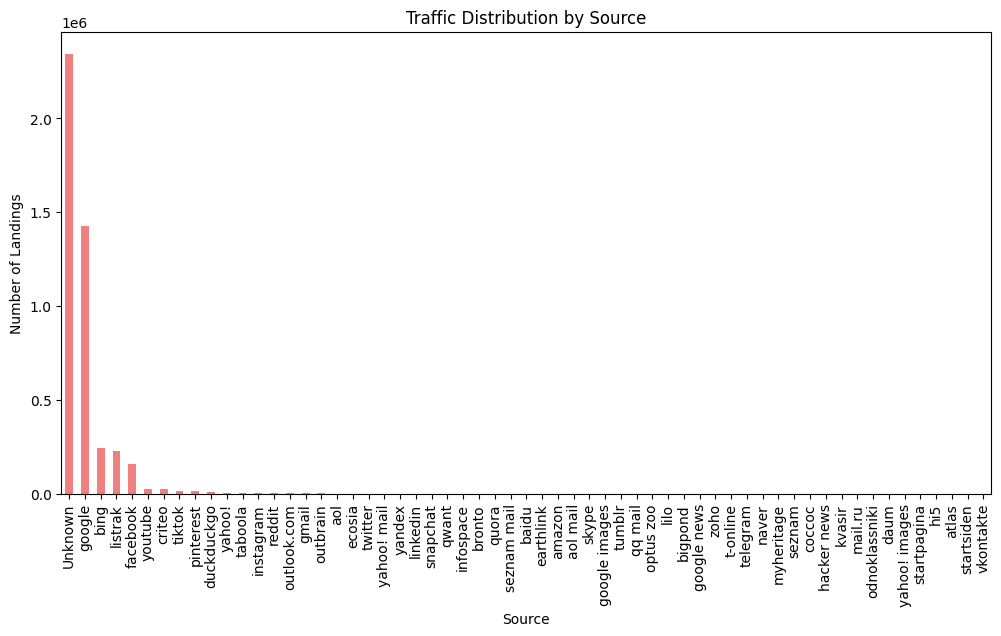

In [35]:
traffic_by_source = website_data['Source'].value_counts()

plt.figure(figsize=(12, 6))
traffic_by_source.plot(kind='bar', color='lightcoral')
plt.title('Traffic Distribution by Source')
plt.ylabel('Number of Landings')
plt.xlabel('Source')
plt.show()


Campaign type analysis

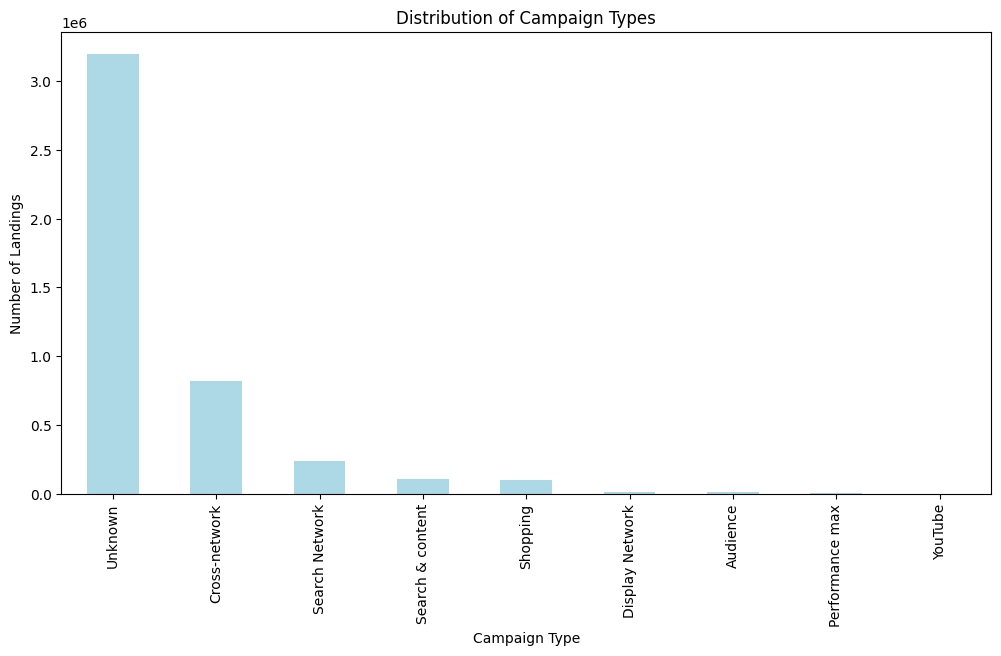

In [36]:
campaign_type_counts = website_data['Campaign Type'].value_counts()

plt.figure(figsize=(12, 6))
campaign_type_counts.plot(kind='bar', color='lightblue')
plt.title('Distribution of Campaign Types')
plt.ylabel('Number of Landings')
plt.xlabel('Campaign Type')
plt.show()

Conversion rate by campaign type

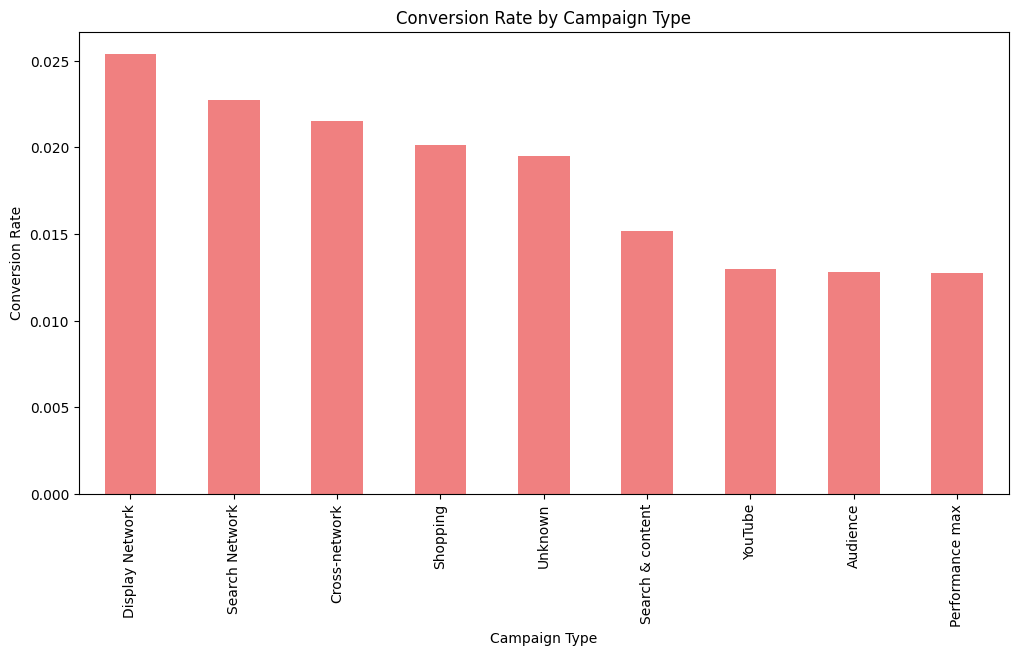

In [37]:
conversion_rate_by_campaign = website_data.groupby('Campaign Type')['Is Converted'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
conversion_rate_by_campaign.plot(kind='bar', color='lightcoral')
plt.title('Conversion Rate by Campaign Type')
plt.ylabel('Conversion Rate')
plt.xlabel('Campaign Type')
plt.show()

Sankey Diagram of Campaign Type and Channel

In [38]:
# X = df[['Is Converted', 'Source', 'Channel', 'Campaign Type', 'Hour', 'Day of Week']]
X = website_data[['Campaign Type','Channel']]

labels = list(pd.unique(X.values.ravel('K')))
 
label_mapping = {label: idx for idx, label in enumerate(labels)}

sources = []
targets = []
values = []

for (campaign_type,channel), count in X.value_counts().items():
    sources.append(label_mapping[campaign_type])
    targets.append(label_mapping[channel])
    values.append(count)

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3"]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(63, 63, 191, 0.4)"
    )
))

fig.update_layout(
    title_text="Sankey Diagram of Campaign Type and Channel",
    font_size=12,
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()

Here are the key observations from the `Campaign Type` vs `Channel` Sankey Diagram:

- The large flow into the "Unknown" channel suggests a need for enhanced tracking mechanisms to better understand user behavior and accurately attribute it to specific channels. 
- Some campaign types, like "paid," are spread across multiple channels such as "Cross-network," "Search Network," and "Shopping," indicating that paid campaigns are utilized across various channels.
- Channels like "YouTube" and "Performance-max" receive flow primarily from the "paid" campaign type, showing that these channels are specifically targeted by paid campaigns.

#### Converting categorical value to numerical category for better analysis and applying ML algorithms

In [39]:
campaign_type_mapping = {category: idx for idx, category in enumerate(data['Campaign type'].unique())}
platform_mapping = {category: idx for idx, category in enumerate(data['Platform'].unique())}
data['Campaign type'] = data['Campaign type'].map(campaign_type_mapping)
data['Platform'] = data['Platform'].map(platform_mapping)

In [40]:
website_data.drop(columns=['User Id'], inplace=True)
website_data.drop(columns=['Website Landing Time'], inplace=True)

source_codes = website_data['Source'].astype('category').cat.codes
channel_codes = website_data['Channel'].astype('category').cat.codes
campaign_type_codes = website_data['Campaign Type'].astype('category').cat.codes
day_of_week_codes = website_data['Day of Week'].astype('category').cat.codes

source_mapping = dict(enumerate(website_data['Source'].astype('category').cat.categories))
channel_mapping = dict(enumerate(website_data['Channel'].astype('category').cat.categories))
campaign_type_mapping = dict(enumerate(website_data['Campaign Type'].astype('category').cat.categories))
day_of_week_mapping = dict(enumerate(website_data['Day of Week'].astype('category').cat.categories))


#### Print mappings

In [41]:
print("Campaign type mapping:")
for key, value in campaign_type_mapping.items():
    print(f"{value}: {key}")

print("\nPlatform mapping:")
for key, value in platform_mapping.items():
    print(f"{value}: {key}")

Campaign type mapping:
Audience: 0
Cross-network: 1
Display Network: 2
Performance max: 3
Search & content: 4
Search Network: 5
Shopping: 6
Unknown: 7
YouTube: 8

Platform mapping:
0: Google Ads
1: Meta Ads
2: Microsoft Ads


In [42]:
print("Source Mapping:", source_mapping)
print("Channel Mapping:", channel_mapping)
print("Campaign Type Mapping:", campaign_type_mapping)
print("Day of Week Mapping:", day_of_week_mapping)

Source Mapping: {0: 'Unknown', 1: 'amazon', 2: 'aol', 3: 'aol mail', 4: 'atlas', 5: 'baidu', 6: 'bigpond', 7: 'bing', 8: 'bronto', 9: 'coccoc', 10: 'criteo', 11: 'daum', 12: 'duckduckgo', 13: 'earthlink', 14: 'ecosia', 15: 'facebook', 16: 'gmail', 17: 'google', 18: 'google images', 19: 'google news', 20: 'hacker news', 21: 'hi5', 22: 'infospace', 23: 'instagram', 24: 'kvasir', 25: 'lilo', 26: 'linkedin', 27: 'listrak', 28: 'mail.ru', 29: 'myheritage', 30: 'naver', 31: 'odnoklassniki', 32: 'optus zoo', 33: 'outbrain', 34: 'outlook.com', 35: 'pinterest', 36: 'qq mail', 37: 'quora', 38: 'qwant', 39: 'reddit', 40: 'seznam', 41: 'seznam mail', 42: 'skype', 43: 'snapchat', 44: 'startpagina', 45: 'startsiden', 46: 't-online', 47: 'taboola', 48: 'telegram', 49: 'tiktok', 50: 'tumblr', 51: 'twitter', 52: 'vkontakte', 53: 'yahoo!', 54: 'yahoo! images', 55: 'yahoo! mail', 56: 'yandex', 57: 'youtube', 58: 'zoho'}
Channel Mapping: {0: 'direct', 1: 'display', 2: 'email', 3: 'organic search', 4: 'pai

In [43]:
data.sample(2)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Reach
5,2024-01-06,4,12860.0,191.0,113.6,3.0,0.0,1,8692.0
415,2024-04-15,7,111208.0,502.0,766.4,14.0,1897.4,2,0.0


In [44]:
website_data.sample(2)

,Is Converted,Source,Channel,Campaign Type,Hour,Day of Week
1905870,0,listrak,email,Unknown,6,Monday
1843234,0,Unknown,direct,Unknown,23,Thursday


In [45]:
website_data['Source'] = source_codes
website_data['Channel'] = channel_codes
website_data['Campaign Type'] = campaign_type_codes
website_data['Day of Week'] = day_of_week_codes

In [46]:
website_data.sample(2)

,Is Converted,Source,Channel,Campaign Type,Hour,Day of Week
4361009,0,0,0,7,4,0
1578077,0,0,2,7,15,2


#### Relationships between numerical variables with different colors representing each platform.

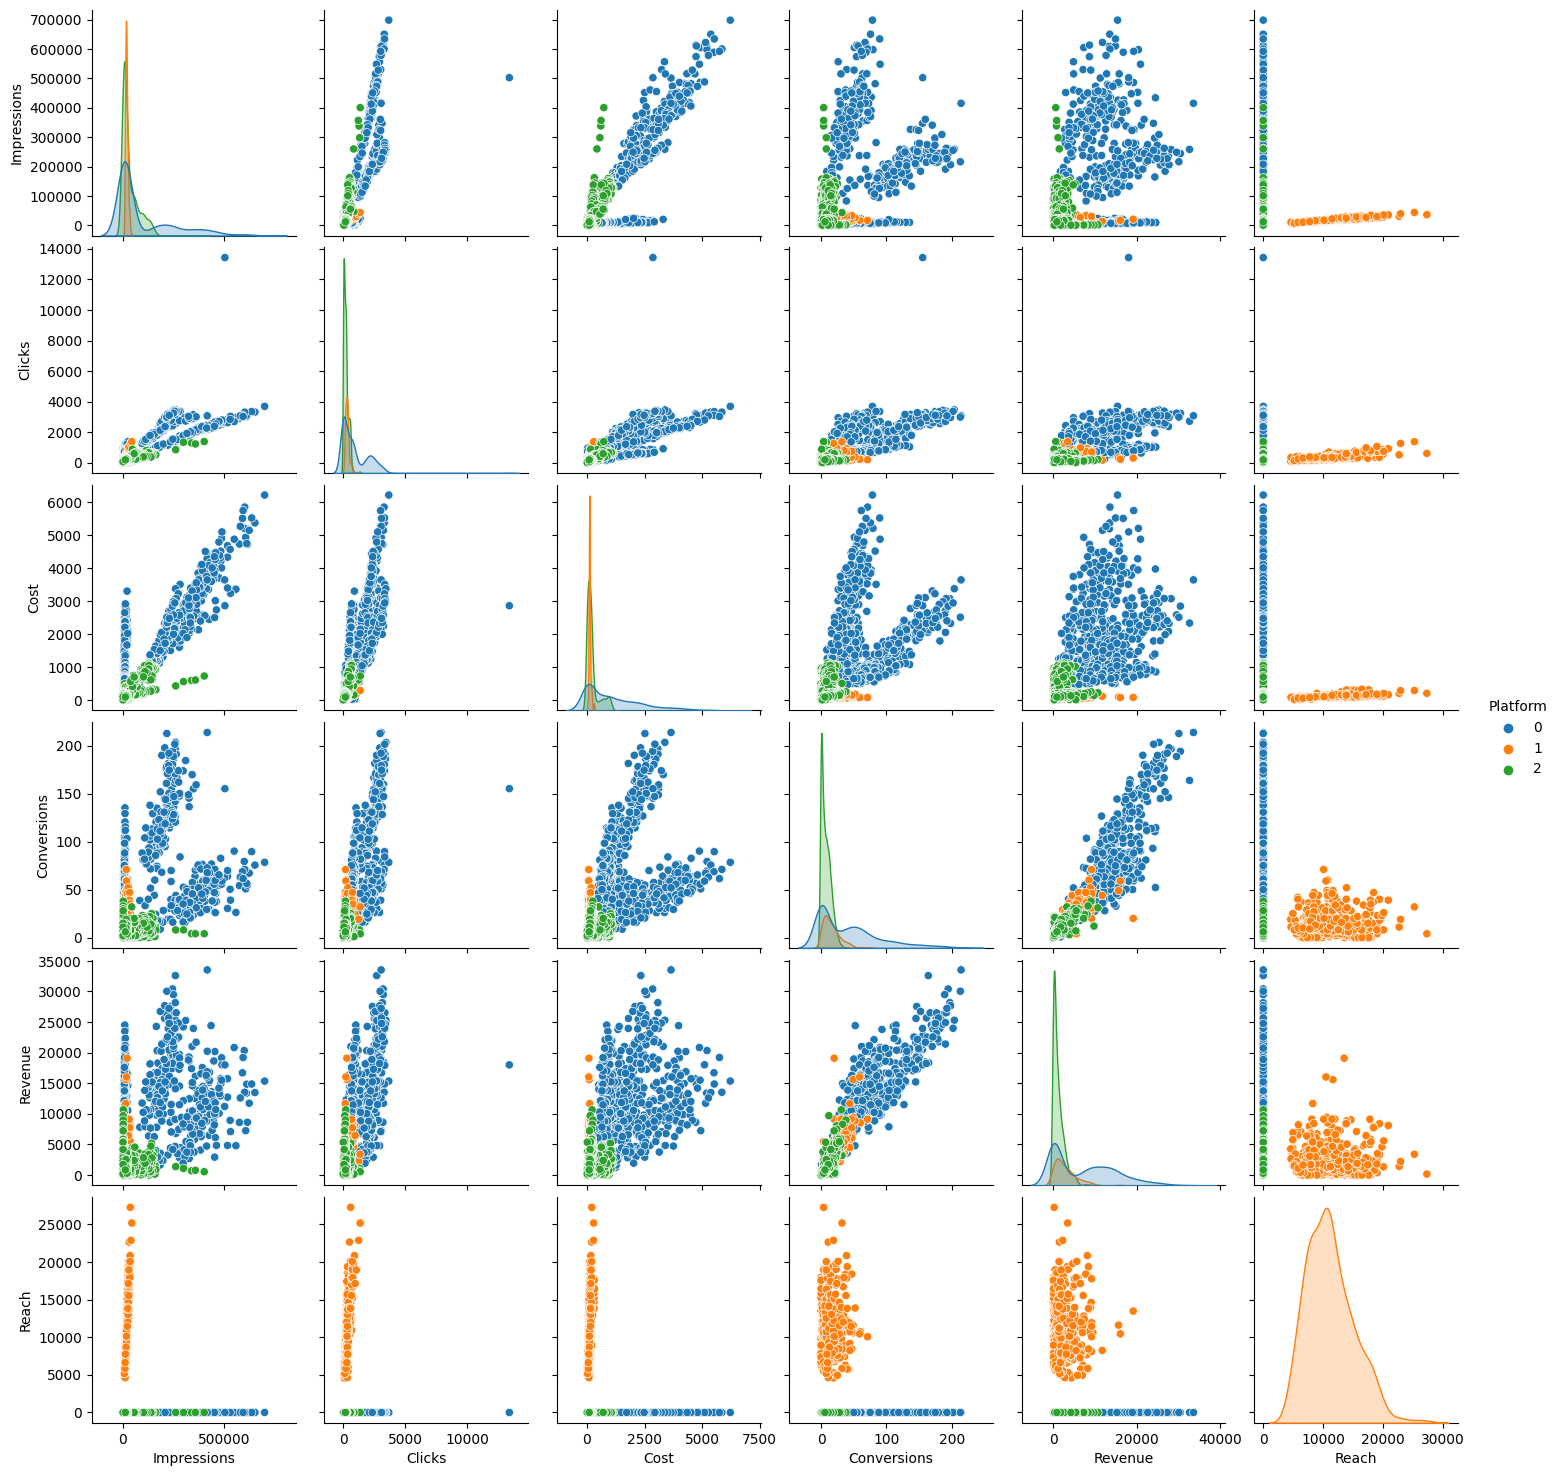

In [47]:
sns.pairplot(data, hue='Platform')
plt.savefig('pairplot.png', format='png')
plt.show()

### Insights from the Pairplot:

1. **Impressions vs. Others:**
   - Strong positive correlation with Clicks, Cost, Conversions, and Revenue for Google Ads and Meta Ads.
   - Lower range of Impressions for Microsoft Ads, limiting correlations.

2. **Clicks vs. Conversions/Revenue:**
   - Positive correlation, especially for Google Ads and Meta Ads.

3. **Cost vs. Others:**
   - Positive correlation with other metrics for Google Ads and Meta Ads.
   - Stable costs in Microsoft Ads suggest different pricing structure.

4. **Conversions vs. Revenue:**
   - Strong linear relationship across all platforms.

5. **Reach:**
   - Significant variation, with Microsoft Ads showing a wider range.

6. **Platform Differences:**
   - Google Ads and Meta Ads show similar patterns, while Microsoft Ads behaves differently, with lower activity but higher Reach.

**Overall Conclusion from ADs Data :**

The dataset shows strong positive correlations between Impressions, Clicks, Conversions, Cost, and Revenue, particularly for Platform  Google Ads and Meta Ads.
Platform Microsoft Ads appears to operate under a different dynamic, with lower activity in most metrics except for Reach. This might indicate a different type of marketing strategy or audience behavior on Platform Microsoft Ads.

#### Feature Engineering

1. Date-Related Features
    - Day of the Week: Extract the day of the week from the Date column to capture potential weekly patterns.
    - Month: Extract the month to account for seasonality.
2. Ratio Features
    - Cost per Click (CPC): Calculate the cost per click using Cost / Clicks.
    - Click Through Rate (CTR): Calculate the click-through rate using Clicks / Impressions.
    - Conversion Rate (CR): Calculate the conversion rate using Conversions / Clicks.
    - Revenue per Conversion: Calculate revenue per conversion using Revenue / Conversions.
3. Interaction Features
    - Cost per Impression: Calculate the cost per impression using Cost / Impressions.
    - Revenue per Click: Calculate the revenue per click using Revenue / Clicks.
4. Campaign Effectiveness
    - Return on Ad Spend (ROAS): Calculate ROAS using Revenue / Cost.
5. Lag Features
    - Previous Day's Metrics: Calculate metrics like Impressions, Clicks, Cost, etc., from the previous day to capture momentum effects.
6. Cumulative Features
    - Cumulative Cost: Calculate the cumulative cost over time to capture how spending builds up.
    - Cumulative Conversions: Calculate cumulative conversions to see how effective campaigns have been over time.
7. Platform-Based Features
    - Platform-Specific Interactions: Create interaction terms between Platform and other key metrics like Cost, Revenue, etc., to capture platform-specific effects.


In [48]:
# 1. Date-Related Features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month

# 2. Ratio Features
data['Cost_per_Click'] = data['Cost'] / data['Clicks']
data['Click_Through_Rate'] = data['Clicks'] / data['Impressions']
data['Conversion_Rate'] = data['Conversions'] / data['Clicks']
data['Revenue_per_Conversion'] = data['Revenue'] / data['Conversions']

# 3. Interaction Features
data['Cost_per_Impression'] = data['Cost'] / data['Impressions']
data['Revenue_per_Click'] = data['Revenue'] / data['Clicks']

# 4. Campaign Effectiveness
data['ROAS'] = data['Revenue'] / data['Cost']

# 5. Lag Features
data['Prev_Day_Impressions'] = data['Impressions'].shift(1)
data['Prev_Day_Clicks'] = data['Clicks'].shift(1)
data['Prev_Day_Cost'] = data['Cost'].shift(1)
data['Prev_Day_Conversions'] = data['Conversions'].shift(1)

# 6. Cumulative Features
data['Cumulative_Cost'] = data['Cost'].cumsum()
data['Cumulative_Conversions'] = data['Conversions'].cumsum()

In [49]:
data.sample(3)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Reach,Day_of_Week,Month,Cost_per_Click,Click_Through_Rate,Conversion_Rate,Revenue_per_Conversion,Cost_per_Impression,Revenue_per_Click,ROAS,Prev_Day_Impressions,Prev_Day_Clicks,Prev_Day_Cost,Prev_Day_Conversions,Cumulative_Cost,Cumulative_Conversions
620,2024-06-05,8,46020.0,219.0,173.7,7.0,4474.5,2,0.0,2,6,0.793151,0.004759,0.031963,639.214286,0.003774,20.431507,25.759931,108512.0,420.0,864.9,16.0,1556327.9,58101.2
696,2024-06-26,2,11763.0,683.0,2919.4,41.5,8817.7,0,0.0,2,6,4.274378,0.058063,0.060761,212.474699,0.248185,12.910249,3.020381,16.0,0.0,0.1,0.0,835518.2,13751.4
182,2024-01-01,4,11560.0,415.0,66.5,8.0,2258.3,1,7851.0,0,1,0.160241,0.035900,0.019277,282.287500,0.005753,5.441687,33.959398,19402.0,261.0,119.7,9.0,1368735.7,52495.2


In [50]:
data.size

63192

In [51]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [52]:
data.size

63192

#### Now we will Analyse the customer behaviour using website_data.

> We assume that each row of the **'website_data'** Dataframe is 1 user's data

In [53]:
website_data.sample(3)

,Is Converted,Source,Channel,Campaign Type,Hour,Day of Week
2464145,0,0,0,7,22,6
1652154,0,0,0,7,18,2
4408733,0,0,0,7,12,1


In [54]:
website_data.groupby('Is Converted').count()

,Source,Channel,Campaign Type,Hour,Day of Week
Is Converted,,,,,
0,4409638,4409638,4409638,4409638,4409638
1,89787,89787,89787,89787,89787


#### Heat Map of Website Data

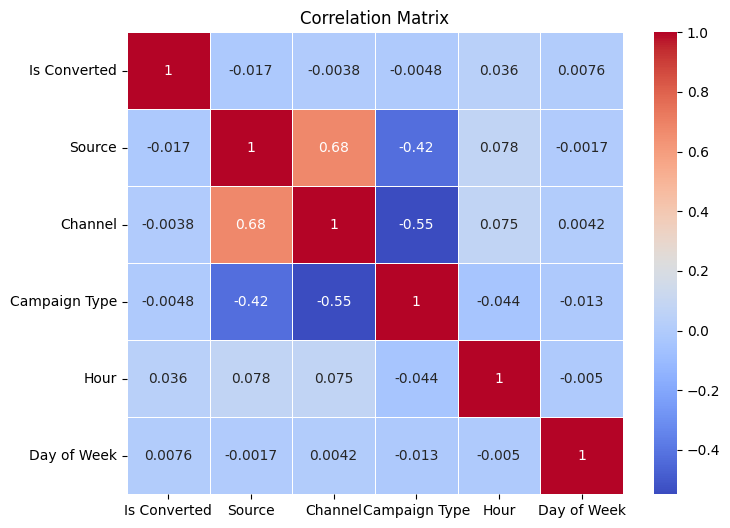

In [55]:
correlation_matrix = website_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Clusters of User Behaviors Based on Hour and Day of Week

In [56]:
X = website_data[['Is Converted', 'Source', 'Channel', 'Campaign Type', 'Hour', 'Day of Week']]
kmeans = KMeans(n_clusters=3, random_state=42) 
website_data['Cluster'] = kmeans.fit_predict(X)

Plotting the clusters

C:\Users\VIVEK KUMAR\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



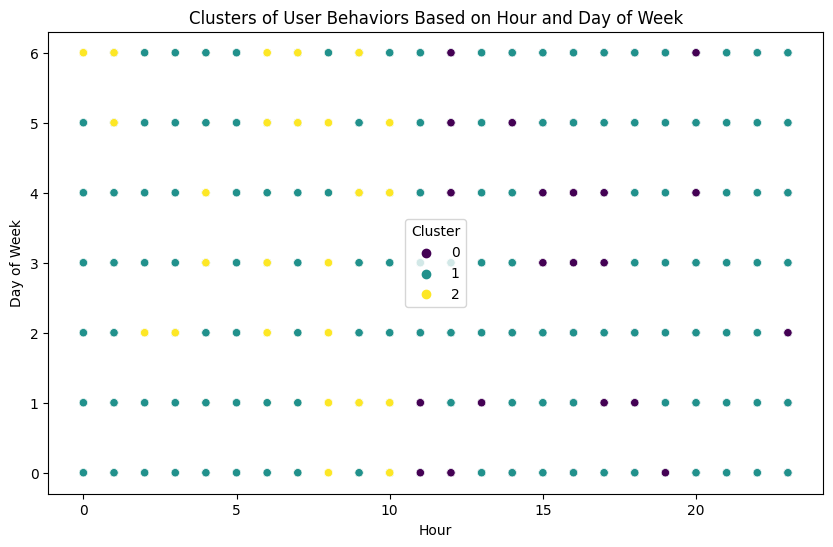

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=website_data, x='Hour', y='Day of Week', hue='Cluster', palette='viridis')
plt.title('Clusters of User Behaviors Based on Hour and Day of Week')
plt.show()

> All the groups are spread across all hours and days without a clear pattern.
>
> * The clusters seem to be evenly distributed across different hours and days of the week, with no significant concentration in specific time slots.
>
> * This indicates that user behaviors, as segmented by the clustering algorithm, are consistent throughout the day and across the week.

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

PCA Component Analysis:
- **PCA Component 1** likely captures the most significant variance related to user engagement and conversion likelihood.
- **PCA Component 2** may represent variations in channel or source preferences, distinguishing users who have specific behavioral patterns.

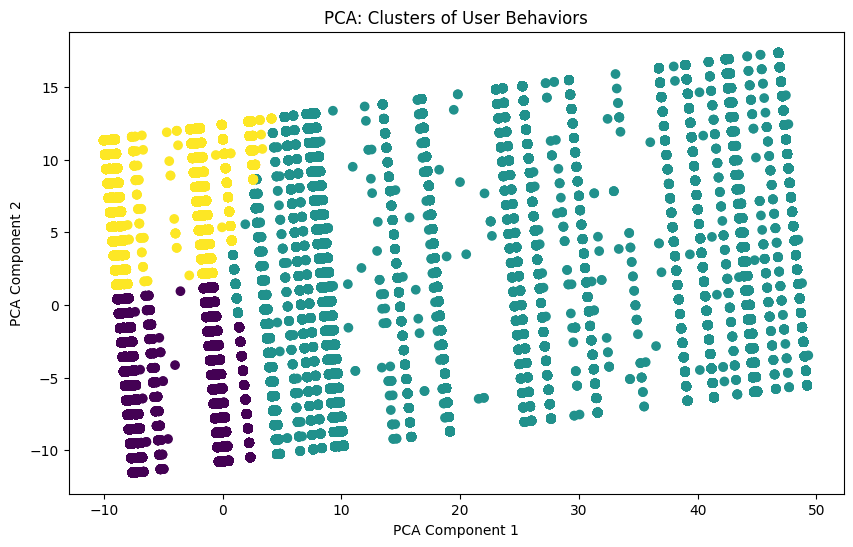

In [59]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA: Clusters of User Behaviors')
plt.show()

The PCA (Principal Component Analysis) graph shows how different user behaviors, as captured by the features are grouped into clusters after dimensionality reduction.

* **The yellow cluster** likely represents a user segment that consistently interacts with specific channels or campaigns in a predictable way. 

* **The purple cluster** is distinct but shows more spread along the vertical axis (PCA Component 2), indicating some variability in behaviors within this group. 

* **The Teal Cluster** is the largest and most spread out along the horizontal axis (PCA Component 1), indicating a diverse range of behaviors. This cluster likely represents a heterogeneous group of users with varying behaviors across multiple dimensions. 

> #### Conclusion
> Marketing Implications:
> - The yellow cluster might be targeted with a consistent message across the board.
> - The purple cluster might benefit from time-based promotions or channel-specific campaigns.
> - The teal cluster might require a more complex strategy, possibly involving dynamic segmentation based on ongoing data collection and analysis.

Clusters of User Behaviors Based on Conversions, Source, Channel, and Campaign Type

In [60]:
X = website_data[['Is Converted', 'Source', 'Channel', 'Campaign Type']]
kmeans = KMeans(n_clusters=3, random_state=42)
website_data['Cluster'] = kmeans.fit_predict(X)

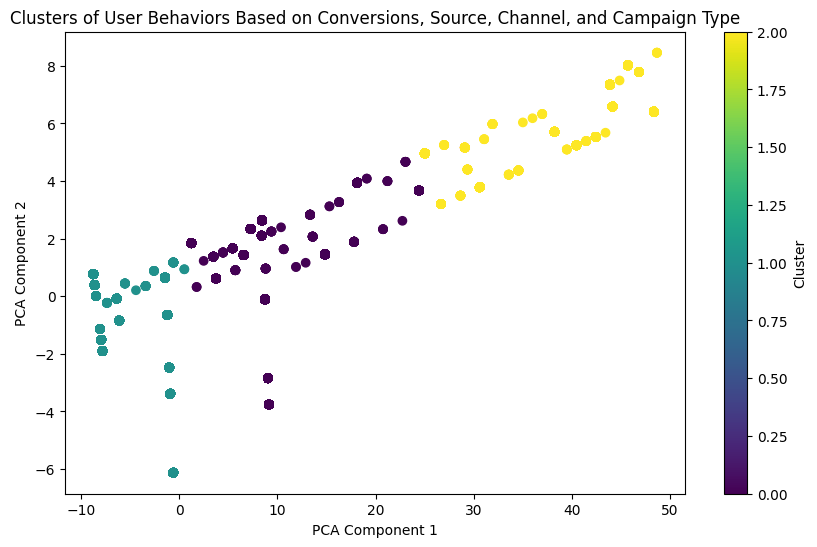

In [61]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=website_data['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of User Behaviors Based on Conversions, Source, Channel, and Campaign Type')
plt.colorbar(label='Cluster')
plt.show()

The PCA plot visually represents how different user behaviors cluster together based on the features. The data has been reduced to two principal components.

- The yellow cluster is located towards the upper right of the PCA space, with high values along both PCA components.
    - high likelihood of conversion
    - likely show strong preferences for specific channels or sources
    - These users could be considered high-value targets for future campaigns

- The purple cluster is situated in the middle of the PCA plot, indicating a moderate score along both PCA components.
    - may have a moderate conversion rate
    - might interact with a variety of channels or sources, showing no strong preference but being influenced by multiple factors.
    - might involve more general marketing approaches or experiments with different campaign types

- The teal cluster is located towards the lower left of the PCA space, indicating lower scores on both PCA components.
    - a lower likelihood of conversion, possibly indicating that they are less engaged
    - might show mixed or unclear preferences for sources or channels
    - represents a challenge, as these users are less responsive to current marketing efforts

<span style="color:lightgreen"><b># The Task for Customer Behaviour Analysis using unsupervised machine learning ends here</b></span>

#### Now we will analyse Ads Data

In [62]:
data.sample(3)

,Date,Campaign type,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Reach,Day_of_Week,Month,Cost_per_Click,Click_Through_Rate,Conversion_Rate,Revenue_per_Conversion,Cost_per_Impression,Revenue_per_Click,ROAS,Prev_Day_Impressions,Prev_Day_Clicks,Prev_Day_Cost,Prev_Day_Conversions,Cumulative_Cost,Cumulative_Conversions
545,2024-05-19,1,12.0,0.0,0.1,0.0,0.0,0,0.0,6,5,0.000000,0.000000,0.000000,0.000000,0.008333,0.000000,0.000000,179544.0,1004.0,1125.0,16.5,657940.8,11332.8
173,2024-02-13,2,16716.0,821.0,2507.1,54.8,11553.9,0,0.0,1,2,3.053715,0.049115,0.066748,210.837591,0.149982,14.072960,4.608472,4.0,0.0,0.0,0.0,217212.7,3578.9
160,2024-06-09,4,19138.0,268.0,122.2,4.0,384.4,1,12912.0,6,6,0.455970,0.014004,0.014925,96.100000,0.006385,1.434328,3.145663,14895.0,183.0,113.8,4.0,1366445.1,52161.2


#### Heat Map of ADs Data

<AxesSubplot: >

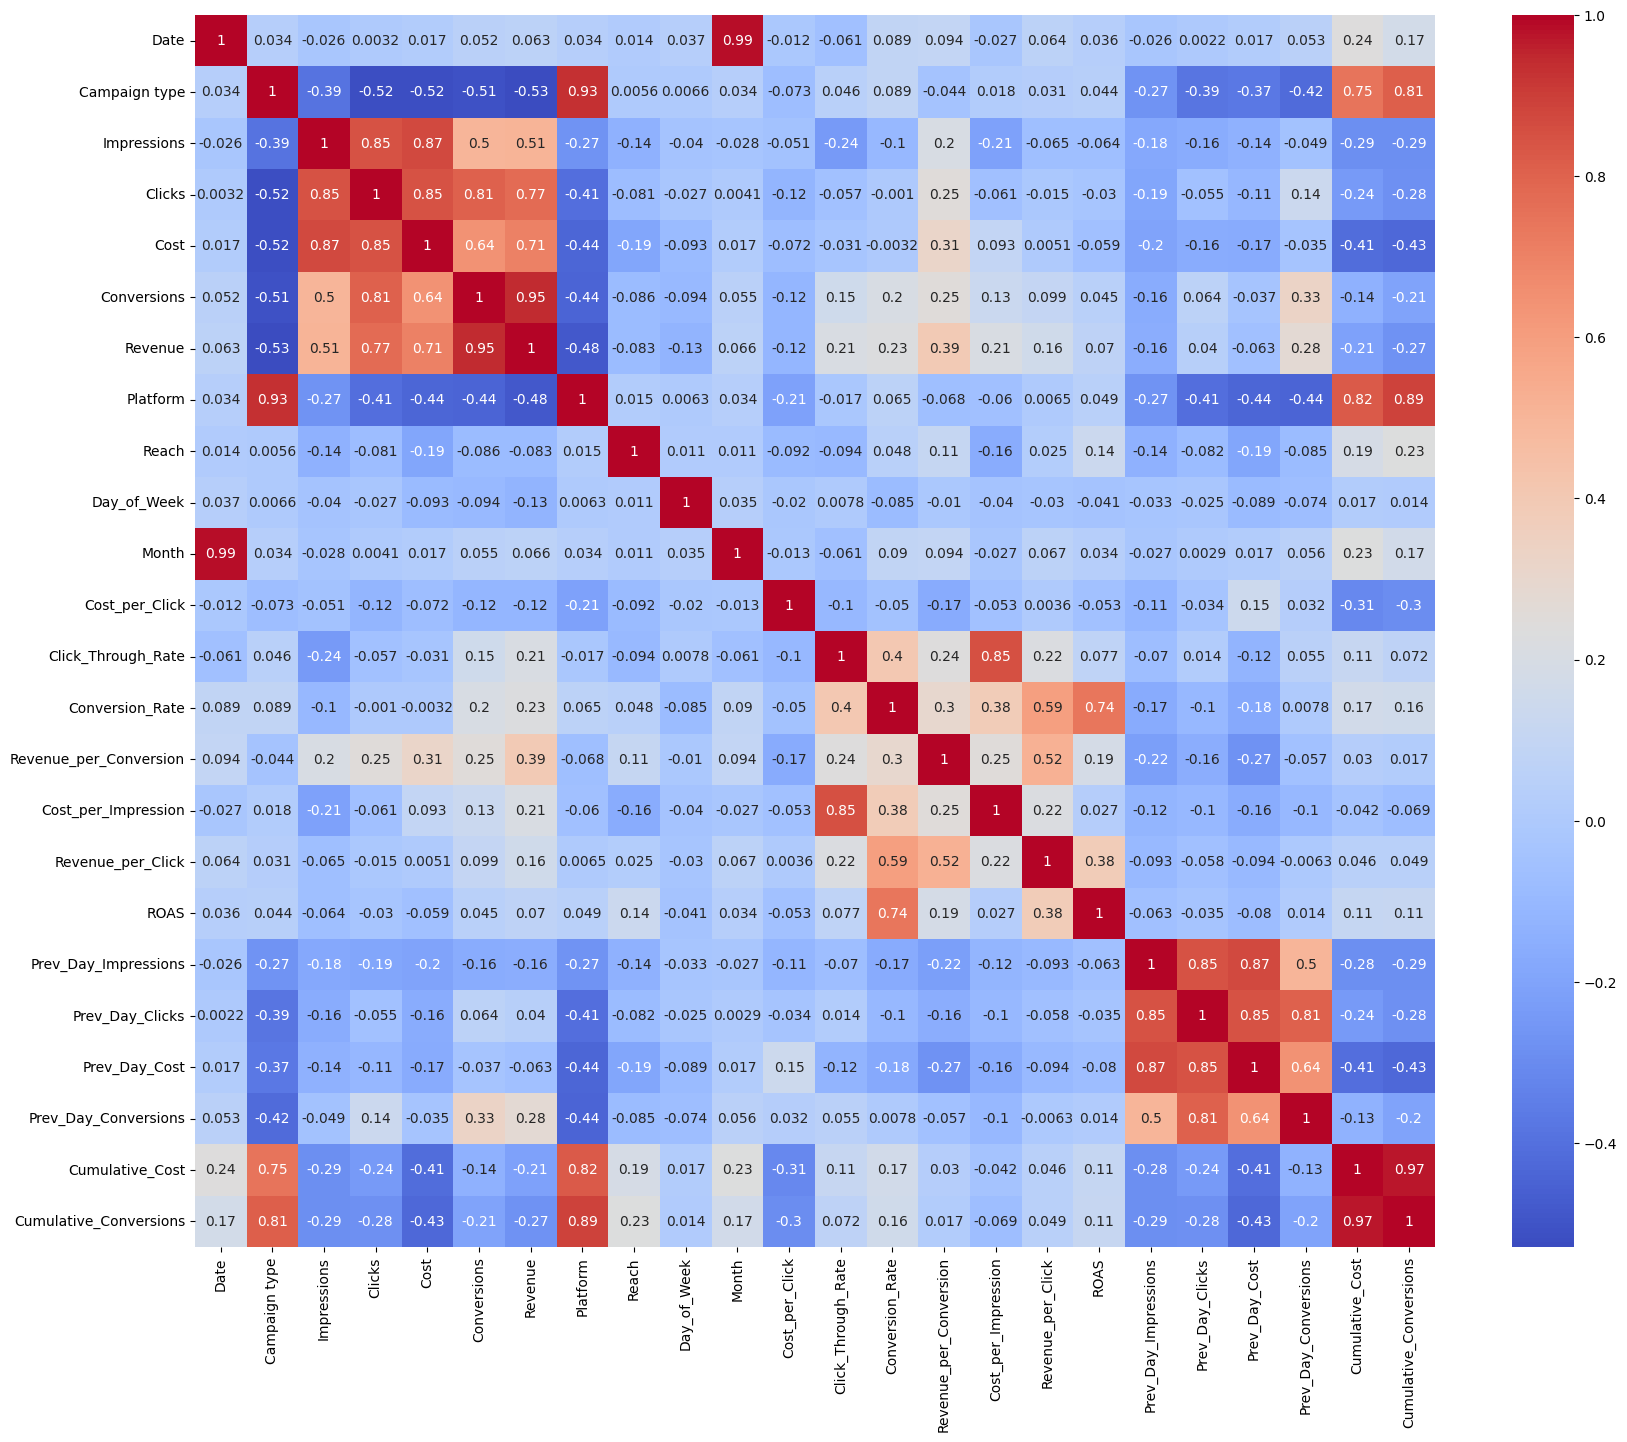

In [63]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
# heatmap_path = "images/heatmap_data.png"
# plt.savefig(heatmap_path)

**Based on the heatmap analysis, the following features appear to be important due to their high correlations with key performance indicators like Conversions, Revenue, and Cost**

* Impressions
* Clicks
* Cost
* Conversions
* Revenue
* Platform
* Click_Through_Rate
* Conversion_Rate
* ROAS
* Cumulative_Cost
* Cumulative_Conversions

In [64]:
selected_features = [
    'Impressions',
    'Clicks',
    'Cost',
    'Conversions',
    'Revenue',
    'Platform',
    'Cost_per_Click',
    'Click_Through_Rate',
    'Conversion_Rate',
    'ROAS',
    'Cumulative_Cost',
    'Cumulative_Conversions'
]

selected_data = data[selected_features]

selected_data.sample(3)


,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Cost_per_Click,Click_Through_Rate,Conversion_Rate,ROAS,Cumulative_Cost,Cumulative_Conversions
633,11925.0,99.0,24.4,0.0,0.0,2,0.246465,0.008302,0.000000,0.000000,1559786.2,58160.2
72,473546.0,2463.0,3707.0,54.4,10077.7,0,1.505075,0.005201,0.022087,2.718559,57286.2,1207.4
115,19440.0,3.0,66.3,0.0,0.0,0,22.100000,0.000154,0.000000,0.000000,115164.6,2123.0


In [65]:
import pandas as pd

selected_features = [
    'Impressions',
    'Clicks',
    'Cost',
    'Conversions',
    'Revenue',
    'Platform',
    'Cost_per_Click',
    'Click_Through_Rate',
    'Conversion_Rate',
    'ROAS',
    'Cumulative_Cost',
    'Cumulative_Conversions'
]

selected_data = data[selected_features]

selected_data = selected_data.fillna(0)

X = selected_data.drop(['Conversions'], axis=1)
y = selected_data['Conversions']

selected_data.sample(3)


,Impressions,Clicks,Cost,Conversions,Revenue,Platform,Cost_per_Click,Click_Through_Rate,Conversion_Rate,ROAS,Cumulative_Cost,Cumulative_Conversions
829,400.0,96.0,143.4,11.0,2507.6,2,1.493750,0.240000,0.114583,17.486750,1593990.3,59927.2
787,394.0,89.0,142.0,16.0,3556.4,2,1.595506,0.225888,0.179775,25.045070,1589355.6,59504.2
388,74396.0,337.0,210.3,10.0,1862.7,2,0.624036,0.004530,0.029674,8.857347,1501367.1,57070.2


> The Regressions models will be trained using features like Impressions, Clicks, Cost, etc., to predict the target variable, which is `Conversions`
>
>>* The trained model will be used to predict the number of conversions for each platform based on the features in the dataset.
>>
>>* These predictions represent the expected performance (in terms of conversions) of each platform if a certain amount of budget is allocated to them.

#### Splitting Dataset for training the ML Model

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training on various regression model and choosing the best among all.

In [67]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

results_list = []

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results_list.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2
    })
results_df = pd.DataFrame(results_list)
print(results_df)

best_model = results_df.loc[results_df['MAE'].idxmin()]

print("-" * 50)
print("\nBest Model Based on Mean Absolute Error (MAE):")
print(best_model)

                      Model        MAE          MSE       RMSE       R^2
0         Linear Regression   5.689408   362.280380  19.033664  0.766921
1          Ridge Regression   5.685110   357.248068  18.901007  0.770159
2          Lasso Regression   5.890350   323.349538  17.981923  0.791968
3     ElasticNet Regression   5.893685   323.791383  17.994204  0.791684
4             Random Forest   2.288336    25.541870   5.053897  0.983567
5         Gradient Boosting   2.611596    25.174673   5.017437  0.983803
6                  AdaBoost   7.639852    91.834294   9.583021  0.940917
7             Decision Tree   3.219355    45.513359   6.746359  0.970718
8  Support Vector Regressor  21.094394  1452.632683  38.113419  0.065427
9       K-Nearest Neighbors   6.549829   120.158020  10.961661  0.922695
--------------------------------------------------

Best Model Based on Mean Absolute Error (MAE):
Model    Random Forest
MAE           2.288336
MSE           25.54187
RMSE          5.053897
R^2   

#### Finetuning the Random Forest Model (best performing model among all)

In [68]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

Training

In [69]:
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) 

# model_filename = 'best_random_forest_model.pkl'
# joblib.dump(best_rf, model_filename)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


#### Plot predicted vs. true values

Best RandomForest Model Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RandomForest Model Performance:
  Mean Absolute Error: 2.256620493358632
  Mean Squared Error: 24.896825175838025
  Root Mean Squared Error: 4.989671850516627
  R^2: 0.9839822490630205


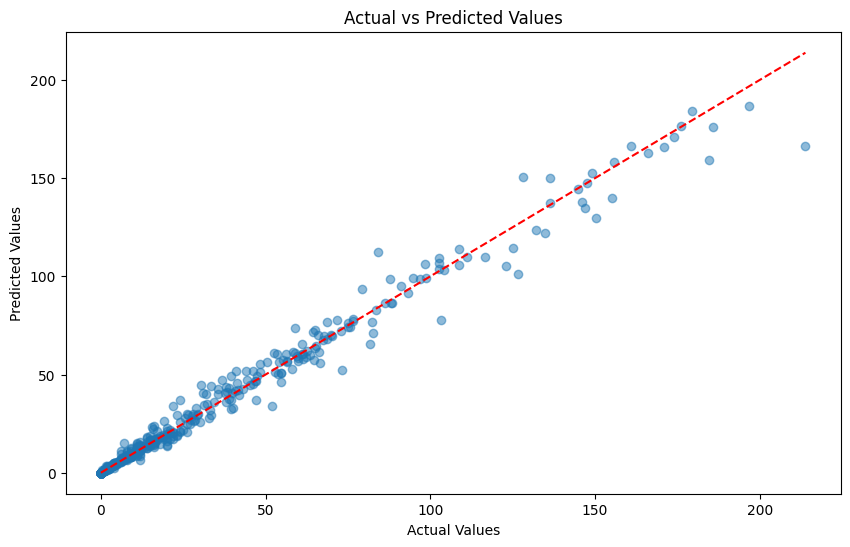

In [70]:
print(f"Best RandomForest Model Parameters: {grid_search.best_params_}")
print(f"Best RandomForest Model Performance:")
print(f"  Mean Absolute Error: {mae}")
print(f"  Mean Squared Error: {mse}")
print(f"  Root Mean Squared Error: {rmse}")
print(f"  R^2: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In case you have saved the model

In [71]:
# model = joblib.load(model_filename)

# y_loaded_pred = model.predict(X_test)

# assert np.allclose(y_pred, y_loaded_pred), "Mismatch between original and loaded model predictions!"


#### Defining function for allocating the Budget

In [72]:
platform_mapping = {
    0: 'Google Ads',
    1: 'Meta Ads',
    2: 'Microsoft Ads'
}

def allocate_budget(predictions, total_budget):
     
    normalized_preds = predictions / predictions.sum()
    allocated_budgets = normalized_preds * total_budget
     
    min_budget = 0.1 * total_budget
    for i in range(len(allocated_budgets)):
        if allocated_budgets[i] < min_budget:
            allocated_budgets[i] = min_budget
     
    allocated_budgets = (allocated_budgets / allocated_budgets.sum()) * total_budget
    
    return allocated_budgets

#### Allocating the Budget of $20000 across different platforms for better conversions.

Total Budget		$20000

        Platform  Allocated Budget
0     Google Ads       8993.543487
1       Meta Ads       2764.906950
2  Microsoft Ads       8241.549563


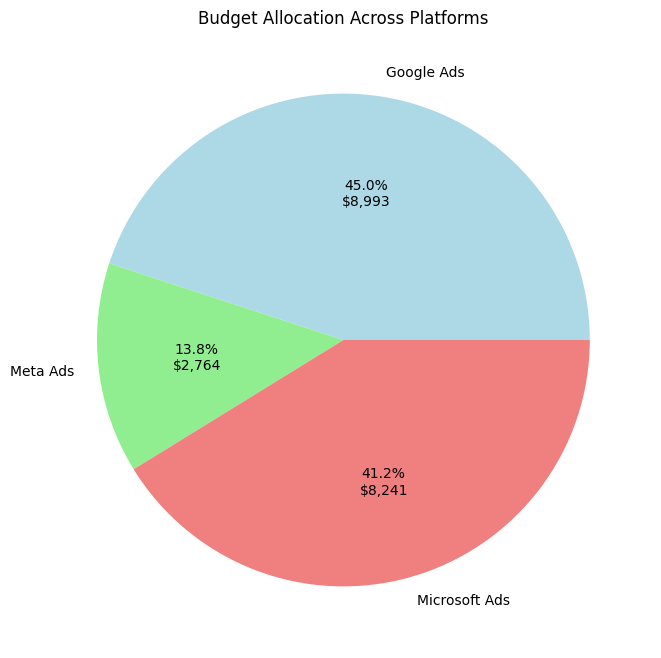

In [73]:
total_budget = 20000

predicted_conversions = model.predict(X)
budget_allocation = allocate_budget(predicted_conversions, total_budget)
 
allocated_budgets_df = pd.DataFrame({
    'Platform': X['Platform'].map(platform_mapping),
    'Allocated Budget': budget_allocation
})
 
budget_summary = allocated_budgets_df.groupby('Platform')['Allocated Budget'].sum().reset_index()
print(f'Total Budget\t\t${total_budget}\n')
print(budget_summary)

plt.figure(figsize=(8, 8))

def format_labels(pct, all_values):
        absolute = int(pct/100. * sum(all_values))
        return f"{pct:.1f}%\n${absolute:,}"

plt.pie(
        budget_summary['Allocated Budget'], 
        labels=budget_summary['Platform'], 
        autopct=lambda pct: format_labels(pct, budget_summary['Allocated Budget']),
        colors=['lightblue', 'lightgreen', 'lightcoral']
)
plt.title('Budget Allocation Across Platforms')
plt.show()

>### Interactive mode for budget allocation
> Just enter the Budget in the interactive textbox widget and press 'Enter'.
>
> 📝 **Note:** 
> 1. <u>'Jupyter Notebook Renderers'</u> plugin may be needed if you want to run the code for allocating the Budget in VS Code in Interactive mode.
>
> 2. please run the cells sequentially to run this cell below as it depends on X. i.e, previous values for predicting conversions and then allocating the budgets according to it.

In [74]:
def update_budget(total_budget):
    predicted_conversions = model.predict(X)
    budget_allocation = allocate_budget(predicted_conversions, total_budget)
    
    allocated_budgets_df = pd.DataFrame({
        'Platform': X['Platform'].map(platform_mapping),
        'Allocated Budget': budget_allocation
    })
    
    budget_summary = allocated_budgets_df.groupby('Platform')['Allocated Budget'].sum().reset_index()
    
    print(budget_summary)

    plt.figure(figsize=(8, 8))

    def format_labels(pct, all_values):
        absolute = int(pct/100. * sum(all_values))
        return f"{pct:.1f}%\n${absolute:,}"

    plt.pie(
        budget_summary['Allocated Budget'], 
        labels=budget_summary['Platform'], 
        autopct=lambda pct: format_labels(pct, budget_summary['Allocated Budget']),
        colors=['lightblue', 'lightgreen', 'lightcoral']
    )
    plt.title('Budget Allocation Across Platforms')
    plt.show()

budget_textbox = widgets.FloatText(
    value=10000, 
    description='Total Budget:',
    step=500,
    continuous_update=False
)

widgets.interactive(update_budget, total_budget=budget_textbox)

interactive(children=(FloatText(value=10000.0, description='Total Budget:', step=500.0), Output()), _dom_class…

<span style="color:lightgreen"><b># The Task for AI Driven Budget allocation across platforms ends here</b></span>

#### Future works

1. Enhanced Machine Learning Model for Budget Allocation
    - Implement a dynamic system where the model adjusts budget allocations in real-time based on ongoing campaign performance.
    - Set up pipelines and integrate the ML models into an automated system
2. User Behavior Analysis and Segmentation
    - urther analyze the clusters identified from the PCA and KMeans results to understand the specific behaviors
    - Conduct a time-series analysis on the data to see how user behaviors change over time and adapt marketing strategies accordingly.
3. Advanced Feature Engineering
    - Create new features that capture the temporal aspects of user behavior
4. Long-Term Strategic Planning
    - Use the insights gained from the current models to predict future trends in user behavior and ad performance


<h1 style="text-align:center; color:#4CAF50; font-family:Arial, sans-serif; font-size:48px;">
  <span style="text-shadow: 2px 2px 4px #000000;">Thank You!</span>
</h1>